## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.regularizers import l1, l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], use_bn=True, drp_ratio=0., l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i), kernel_regularizer=l2(l2_ratio))(input_layer)
            
            if use_bn == True:
                x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i), kernel_regularizer=l2(l2_ratio))(x)

            if use_bn == True:
                x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(drp_ratio)(x)
                
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 1e-3
DRP_RATIO = [0.3,0.6]
L2_RATIO = [0, 1e-4, 1e-8]
BN_SWITCH = [True, False]
MOMENTUM = 0.95

In [7]:
list(itertools.product(BN_SWITCH, L2_RATIO, DRP_RATIO))

[(True, 0, 0.3),
 (True, 0, 0.6),
 (True, 0.0001, 0.3),
 (True, 0.0001, 0.6),
 (True, 1e-08, 0.3),
 (True, 1e-08, 0.6),
 (False, 0, 0.3),
 (False, 0, 0.6),
 (False, 0.0001, 0.3),
 (False, 0.0001, 0.6),
 (False, 1e-08, 0.3),
 (False, 1e-08, 0.6)]

In [8]:
results = {}

for i, (bn, l2r, drp) in enumerate(itertools.product(BN_SWITCH, L2_RATIO, DRP_RATIO)):
    model = build_mlp(input_shape=x_train.shape[1:],  use_bn=bn, drp_ratio=drp, l2_ratio=l2r)
    model.summary()
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True)

    name = "bn-%s-drp-%s-l2-%s" %(str(bn), str(drp), str(l2r))
    results[name] = {
        'train_loss': model.history.history['loss'],
        'val_loss': model.history.history['val_loss'],
        'train_acc': model.history.history['accuracy'],
        'val_acc': model.history.history['val_accuracy']
    }

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 83us/step - loss: 2.3668 - accuracy: 0.2316 - val_loss: 2.0128 - val_accuracy: 0.3463
Epoch 2/10
50000/50000 [==============================] - 3s 69us/step - loss: 2.0463 - accuracy: 0.3229 - val_loss: 1.8354 - val_accuracy: 0.4027
Epoch 3/10
50000/50000 [==============================] - 3s 69us/step - loss: 1.9424 - accuracy: 0.3567 - val_loss: 1.7627 - val_accuracy: 0.4306
Epoch 4/10
50000/50000 [==============================] - 3s 69us/step - loss: 1.8810 - accuracy: 0.3730 - val_loss: 1.7253 - val_accuracy: 0.4377
Epoch 5/10
50000/50000 [==============================] - 3s 69us/step - loss: 1.8394 - accuracy: 0.3899 - val_loss: 1.7001 - val_accuracy: 0.4448
Epoch 6/10
50000/50000 [==============================] - 3s 69us/step - loss: 1.7972 - accuracy: 0.4058 - val_loss: 1.6748 - val_accuracy: 0.4565
Epoch 7/10
50000/50000 [==============================] - 3s 68us/st

50000/50000 [==============================] - 3s 69us/step - loss: 1.8035 - accuracy: 0.3575 - val_loss: 1.6195 - val_accuracy: 0.4326
Epoch 4/10
50000/50000 [==============================] - 3s 69us/step - loss: 1.7376 - accuracy: 0.3798 - val_loss: 1.5921 - val_accuracy: 0.4382
Epoch 5/10
50000/50000 [==============================] - 3s 70us/step - loss: 1.6970 - accuracy: 0.3922 - val_loss: 1.5609 - val_accuracy: 0.4539
Epoch 6/10
50000/50000 [==============================] - 3s 70us/step - loss: 1.6564 - accuracy: 0.4058 - val_loss: 1.5189 - val_accuracy: 0.4629
Epoch 7/10
50000/50000 [==============================] - 3s 69us/step - loss: 1.6275 - accuracy: 0.4156 - val_loss: 1.5077 - val_accuracy: 0.4679
Epoch 8/10
50000/50000 [==============================] - 3s 70us/step - loss: 1.6000 - accuracy: 0.4267 - val_loss: 1.4824 - val_accuracy: 0.4742
Epoch 9/10
50000/50000 [==============================] - 3s 70us/step - loss: 1.5764 - accuracy: 0.4358 - val_loss: 1.4684 - val

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_22 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_23 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0   

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 62us/step - loss: 2.4842 - accuracy: 0.1132 - val_loss: 2.4041 - val_accuracy: 0.1903
Epoch 2/10
50000/50000 [==============================] - 3s 56us/step - loss: 2.3971 - accuracy: 0.1412 - val_loss: 2.3244 - val_accuracy: 0.2244
Epoch 3/10
50000/50000 [==============================] - 3s 56us/step - loss: 2.3494 - accuracy: 0.1650 - val_loss: 2.2633 - val_accuracy: 0.2355
Epoch 4/10
50000/50000 [==============================] - 3s 56us/step - loss: 2.3014 - accuracy: 0.1812 - val_loss: 2.2138 - val_accuracy: 0.2582
Epoch 5/10
50000/50000 [==============================] - 3s 56us/step - loss: 2.2660 - accuracy: 0.1910 - val_loss: 2.1693 - val_accuracy: 0.2829
Epoch 6/10
50000/50000 [==============================] - 3s 57us/step - loss: 2.2379 - accuracy: 0.2043 - val_loss: 2.1319 - val_accuracy: 0.2882
Epoch 7/10
50000/50000 [==============================] - 3s 57us/st

In [13]:
len(color_bar)

25

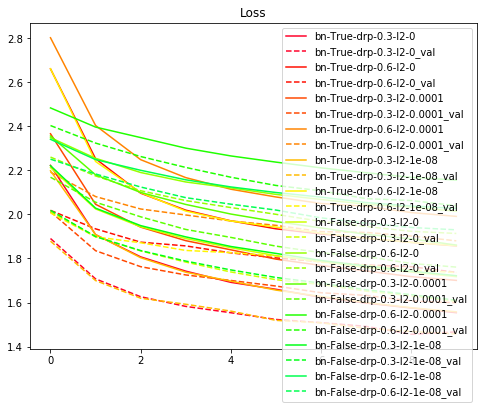

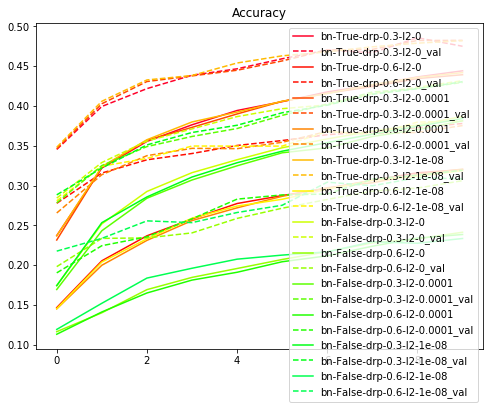

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap= mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train_loss"])), results[cond]["train_loss"], '-', label=cond, c=color_bar[i])
    plt.plot(range(len(results[cond]["val_loss"])), results[cond]["val_loss"], '--', label=cond+"_val", c=color_bar[i])
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train_acc"])), results[cond]["train_acc"], '-', label=cond, c=color_bar[i])
    plt.plot(range(len(results[cond]["val_acc"])), results[cond]["val_acc"], '--', label=cond+"_val", c=color_bar[i])
plt.title('Accuracy')
plt.legend()
plt.show()